In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import numpy as np

# import eyetrack

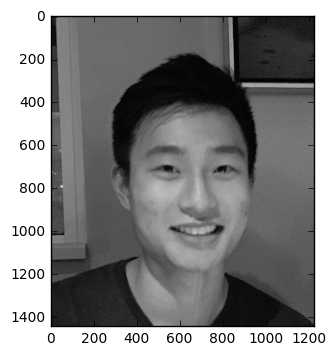

In [41]:
im = cv2.imread('../images/face.jpg')

im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

# plt.axis("off")
plt.imshow(im_gray, cmap='gray')
plt.show()

In [28]:
coords = detect_pupils(im_gray)

more than 2 eyes detected
(2, 4)
PUPIL ROW, COL:
709, 790
PUPIL ROW, COL:
711, 542


In [29]:
print(coords)

[(790.04697986577185, 709.34228187919462), (542.13761467889913, 711.44036697247702)]


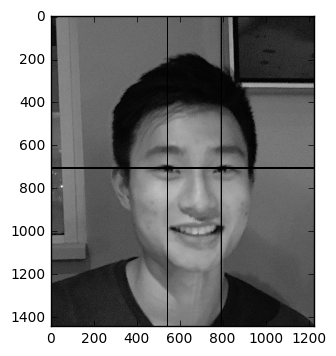

In [42]:
im_disp = np.copy(im_gray)
for (x, y) in coords:
    plot_pupil(im_disp, y, x)
    
plt.imshow(im_disp, cmap='gray')
plt.show()

In [35]:
print(im_disp.shape)

(1443, 1227)


In [40]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

def detect_pupils(im):
    ''' The input im is a grayscale image array. '''
    cascade_path = '/Users/Kepler/anaconda/pkgs/opencv3-3.1.0-py27_0/share/OpenCV/haarcascades/'

    face_cascade = cv2.CascadeClassifier(cascade_path + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cascade_path + 'haarcascade_eye.xml')

    im_result = np.copy(im)
    # faces = face_cascade.detectMultiScale(im_gray, 1.3, 5)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(
        im,
        scaleFactor=1.2,
        minNeighbors=5,
    #     maxSize(500, 500),
        minSize=(30, 30)
    )

    # the detectMultiScale function returns the (x, y, w, h) were x, y is the top left corner of the detected rectangle
    for (x,y,w,h) in faces:
        roi_gray = im[y:y+h, x:x+w]
        roi_color = im_result[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(
            roi_gray,
            minNeighbors=5,
            minSize=(0, 0)
        )

    if eyes.shape[0] != 2:
        print('more than 2 eyes detected')
        eyes = eliminate_fp(eyes)
        
    print(eyes.shape)

    pupil_coords = []

    for eye in eyes:
        x, y = faces[0, 0:2] + eye[0:2]
        w, h = eye[2:]

        left_eye = im[y:y + h, x:x + w]

        hist, bins = np.histogram(left_eye.flatten(), 256, [0, 256])

        cdf = hist.cumsum()
        # cdf_normalized = cdf * hist.max() / cdf.max()
        cdf_normalized = cdf / cdf.max()

        # cdf_normalized = cdf_normalized / float(cdf_normalized.max())

        working_eye = np.copy(left_eye)

        for i in range(0, working_eye.shape[0]):
            for j in range(0, working_eye.shape[1]):
                intensity = working_eye[i, j]
                cdf_value = cdf_normalized[intensity]
                if cdf_value < 0.05:
                    working_eye[i, j] = 255
                else:
                    working_eye[i, j] = 0

        result_eye = np.copy(working_eye)
        min_filter(result_eye, 2)

        # Obtaining the Pixel of Minimum Intensity
        pmi_eye = np.copy(result_eye)
        pmi = 255
        pmi_coords = (0, 0)
        for i in range(0, pmi_eye.shape[0]):
            for j in range(0, pmi_eye.shape[1]):
                if pmi_eye[i, j] == 255:
                    if left_eye[i, j] < pmi:
                        pmi = left_eye[i, j]
                        pmi_coords = (i, j)

        ai_area = left_eye[pmi_coords[0] - 5:pmi_coords[0] + 6, pmi_coords[1] - 5:pmi_coords[1] + 6]

        ai = avg_intensity(ai_area)

        count = 0
        row_sum = 0
        col_sum = 0
        for i in range(pmi_coords[0] - 7, pmi_coords[0] + 8):
            for j in range(pmi_coords[1] - 7, pmi_coords[1] + 8):
                if left_eye[i, j] < ai:
                    count += 1
                    row_sum += i
                    col_sum += j

        centroid_row = float(row_sum) / count
        centroid_col = float(col_sum) / count

        pupil_row = centroid_row + y
        pupil_col = centroid_col + x

        print('PUPIL ROW, COL:')
        print('%d, %d' % (pupil_row, pupil_col))

        pupil_coords.append((pupil_col, pupil_row))

    return pupil_coords


def avg_intensity(ai_area):
    ai_sum = 0
    for i in range(0, ai_area.shape[0]):
        for j in range(0, ai_area.shape[1]):
            ai_sum += ai_area[i, j]
    ai = float(ai_sum) / ai_area.size
    return ai


def min_filter(im, radius):
    bw_im = np.copy(im)
    for i in range(0, bw_im.shape[0]):
        for j in range(0, bw_im.shape[1]):
            radius_min = 255  # the minimum intensity within the radius
            for p in range(i - radius, i + radius + 1):
                for q in range(j - radius, j + radius + 1):
                    # making sure the indices don't go out of bounds
                    row = 0 if p < 0 else p
                    col = 0 if q < 0 else q
                    row = bw_im.shape[0] - 1 if p >= bw_im.shape[0] else row
                    col = bw_im.shape[1] - 1 if q >= bw_im.shape[1] else col

                    intensity = bw_im[row, col]
                    if intensity < radius_min:
                        radius_min = intensity

            bw_im[i, j] = radius_min

    return bw_im

def eliminate_fp(eyes_arr):
    eyes = np.copy(eyes_arr)
    eyes_area = []
    for eye in eyes:
        area = eye[2] * eye[3]
        eyes_area.append(area)

    avg_area = sum(eyes_area) / len(eyes_area)

    while eyes.shape[0] != 2:
        max_diff = 0
        max_diff_index = 0
        for i in range(0, len(eyes_area)):
            diff = (avg_area - eyes_area[i]) ^ 2
            if diff > max_diff:
                max_diff = diff
                max_diff_index = i

                #         eyes = np.delete(eyes, (i,:))
        eyes = np.delete(eyes, (max_diff_index), axis=0)
        
    return eyes

def plot_pupil(im, pupil_row, pupil_col):
    pupil_row = int(pupil_row)
    pupil_col = int(pupil_col)
    cv2.line(im, (0, pupil_row), (im.shape[1] - 1, pupil_row), (0, 0, 0), 3)
    cv2.line(im, (pupil_col, 0), (pupil_col, im.shape[0] - 1), (0, 0, 0), 3)
    return im
